# Topic Model Machine
## William Harding <a href="mailto:william.jeffrey.harding@gmail.com"> Email  </a>
### A systematic way to quickly build and look at topical models. 
Topic modeling with real datasets requires a lot of cleaning and tweaking of the data to get valuable insights. Because the process is very iterative,  I built a process to move through models quickly and compare them to each other. 

In [1]:
import matplotlib 
get_ipython().magic(u'matplotlib inline')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
#import pyLDAvis
##import pyLDAvis.sklearn

from __future__ import print_function
from time import time
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [7]:
n_samples = 2000
n_features = 10000
n_topics = 20
n_top_words = 100


Stopwords. You may need to run nltk.download() to get the corpus needed, including the defauilt stoplist. 

In [9]:
from nltk.corpus import stopwords
mystopwords = stopwords.words("english")   #default list from NTLK

#More stop words - once you run the document, you may find words that aren't helping your model
#go back to this step to add more words and run again.
more_stop_words = ['like','linkedin','twitter','facebook','would','think','google',
                   'nursing','patient','care','patients','financial']  
[mystopwords.append(x) for x in more_stop_words]


[None, None, None, None, None, None, None, None, None, None, None, None]

Load the documents into dataframe, they must be loaded in DICT like format. This step requires the most customized work, as the format of your input data will be  different. 
* End result is that your dataset is a dictionary with keys that you can match up later.  
* You will also need a dataframe that you can match the scores back up to.
* Data is cleaned at this point, I like to leave the origional text in tact, but that's up to you

In [2]:
#Using a list of documents from 'trusted news sources'
df = pd.read_excel(r'C:\Users\v-wihar\mydocfile.xlsx')

#clean the docs (while leaving the origional in tact)
docs = df['Content'].str.lower().replace({r'\n': ' ','[^&a-zA-Z]':' ','\s+': ' '}, regex=True).tolist()

corpus = {} 
for i in range(len(docs)):
    corpus[i] = docs[i]
#print(df.index[4], '\n',corpus[4])   #just printing out one for an example
print("total documents in corpus:",len(corpus.keys()))

total documents in corpus: 530


In [3]:
df.head()

,Type,Source,Count,Link,Title,Content
0,Finance,Fortune,1,http://fortune.com/2016/11/16/krispy-kreme-law...,Krispy Kreme Is Being Sued For Not Using Real ...,The lawsuit claims the company is robbing cust...
1,Healthcare,PubMed,1,https://www.ncbi.nlm.nih.gov/pubmed/27834777/,The Road Less Traveled: Alternative Pathways f...,1Laboratory of Experimental Psychology and Neu...
2,Finance,Fortune,2,http://fortune.com/2016/11/16/elizabeth-warren...,"Elizabeth Warren Threatens Trump: Don't Let ""W...",As she calls for an overhaul.\n\nPresident-ele...
3,Healthcare,PubMed,2,https://www.ncbi.nlm.nih.gov/pubmed/27841876/,Cardioprotection and lifespan extension by the...,"1Institute of Molecular Biosciences, NAWI Graz..."
4,Finance,Fortune,3,http://fortune.com/2016/11/16/koch-industries-...,Koch Industries Pours $2.5 Billion into Busine...,Infor brings digital expertise to Koch Industr...


Default functions and globals that you will need for your model. 

In [10]:
data_samples = corpus.values()
tf_vectorizer = CountVectorizer(strip_accents='unicode',
                                lowercase= True,
                                token_pattern=r'\b[a-zA-Z]{3,}\b',
                                max_features=n_features,
                                stop_words=mystopwords,
                                max_df=0.7,  #change max/min_df to be more or less selective with stopwords.
                                min_df=.2)

tf = tf_vectorizer.fit_transform(data_samples)

lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0
                                )
lda.fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names()

#bunch of functions that I wrote to build the tables for the model:
def get_single_topic(lda, tf_feature_names, n_top_words, topic):
    words = [tf_feature_names[i] for i in lda.components_[topic].argsort()[:-n_top_words - 1:-1]]
    scores = lda.components_[topic][lda.components_[topic].argsort()[:-n_top_words - 1:-1]]
    df = pd.DataFrame(index=words,columns=['topic_{}'.format(topic)],data=scores)
    return df

def get_all_topics(lda, tf_feature_names, n_top_words,n_topics):
    df = pd.DataFrame()
    for topic in range(n_topics):
        tmpdf = get_single_topic(lda, tf_feature_names, n_top_words, topic)
        for item in tmpdf.index:
            df.loc[item,'topic_{}'.format(topic)] = tmpdf.loc[item,'topic_{}'.format(topic)]
    return df

def get_topic_names(lda, tf_feature_names, n_top_words, n_topics):
    themes = pd.Series()
    for topic in range(n_topics):
        theme = " ".join([tf_feature_names[i] for i in lda.components_[topic].argsort()[:-n_top_words - 1:-1]])
        themes.loc['topic_{}'.format(topic)] = theme
    return themes


In [11]:
def score_document(doc_dic,df,lda, tf_feature_names, n_top_words, n_topics,
                    returnDF=True,confidence=.01):
    '''
    gives scores to the origional document, assigning a category to each one. 

    returnDF : By default returns a DataFrame, set to false to return a dict.
    confidence : this is the threashold that the model must meet to match the document to a topic.
    set to .01 to include practically everything, set to .99 to include almost nothing.

    document_scores = score_document(doc_dic,df,lda, tf_feature_names, n_top_words, n_topics)
    '''
    results_dict = {}
    for key, item in enumerate(doc_dic.keys()):
        document = doc_dic[item]
        words = [tf_feature_names[i] for i in tf.getrow(list(doc_dic).index(item)).indices]
        scores = df[[word in words for word in df.index]]
        TM_Score = pd.DataFrame()
        TM_Score['docScore'] = scores.sum() 
        TM_Score['theme'] = get_topic_names(lda, tf_feature_names, n_top_words, n_topics)
        results = TM_Score['docScore'].fillna(0).to_dict()
        results['document'] = document
        results['key'] = item
        results['top_score'] = TM_Score['docScore'].max()

        if TM_Score['docScore'].max() >= confidence:
            results['top_theme'] = TM_Score['theme'][TM_Score['docScore'].tolist().index(TM_Score['docScore'].max())]
            results['top_topic'] = TM_Score.index[TM_Score['docScore'].tolist().index(TM_Score['docScore'].max())]
        else: 
            results['top_theme'] = 'unassigned'
            results['top_topic'] = 'unassigned'
        results_dict[key] = results
    if returnDF:
        return pd.DataFrame(results_dict).T
    else:
        return results_dict

In [12]:
Scored_words = get_all_topics(lda, tf_feature_names, n_top_words,n_topics)
Scored_corpus = score_document(corpus,Scored_words,lda, tf_feature_names, n_top_words, n_topics)
get_topic_names = pd.DataFrame(get_topic_names(lda, tf_feature_names, n_top_words, n_topics))
get_topic_names

,0
topic_0,access available review based also medical res...
topic_1,day one three medicine years could best withou...
topic_2,year also risk take help much even could may t...
topic_3,said new medicine also many risk two state thr...
topic_4,time practice one using risk also number use m...
topic_5,new health states public people could one even...
topic_6,people need one work get take help time practi...
topic_7,new made information long national first high ...
topic_8,research results data information best includi...
topic_9,health public states need available may many p...


In [13]:
Scored_words.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
access,127.307985,0.381707,0.281123,0.304111,15.922154,0.277558,0.812756,3.831084,0.249130,24.227707,2.970706,3.374430,10.300382,0.276668,0.506656,0.973130,3.191004,1.197287,14.639673,0.295781
available,20.830325,1.645885,0.270499,0.334323,17.129983,0.297076,3.753755,0.895589,0.272287,52.452843,33.078504,1.409400,6.851767,3.298101,2.509197,1.555559,13.844632,3.273995,23.286746,0.372354
review,11.788290,0.295308,0.386939,0.297304,15.549230,0.275622,1.036877,3.470775,0.295142,1.198036,37.335666,0.580317,0.615113,0.309694,2.744244,2.335618,9.863042,7.736897,110.568089,0.340128
based,10.211550,0.332064,0.250687,0.497122,24.468554,0.251056,1.772501,1.942718,0.278441,25.660233,41.483951,2.622659,17.929677,0.569532,3.123474,5.353046,2.741267,89.823309,45.849364,0.273829
also,8.229535,2.550849,0.828531,0.715509,50.659350,0.385913,45.496833,4.349098,0.301310,31.887668,46.182340,3.898165,101.874074,1.391558,101.559371,30.076346,13.959818,11.751724,22.116654,0.560751


Now we have to get the output into some formats that we can digest. I'm using Excel for visualization in this case so I'll just want to make some various tables. Note that If  you kept your indexes the same (didn't reset them) then your can match the topic scores directly on top of any  metadata that you collected about the topics.  

In [14]:
norm_scored_words = pd.DataFrame()
for topic in Scored_words.columns:
    tmp = (Scored_words[topic] - Scored_words[topic].mean()) / (Scored_words[topic].max() - Scored_words[topic].min())
    norm_scored_words[topic] = tmp
norm_scored_words.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
access,0.962273,-0.032669,-0.109315,-0.112111,-0.072411,-0.103087,-0.176610,-0.008407,-0.122023,-0.010859,-0.131769,-0.027194,-0.145207,-0.100007,-0.116777,-0.050202,-0.061369,-0.056671,-0.047807,-0.128153
available,0.123951,-0.003430,-0.120891,-0.081834,-0.060357,-0.041129,-0.155279,-0.023290,-0.071463,0.024956,-0.012296,-0.038770,-0.161806,0.236624,-0.096976,-0.048204,0.011067,-0.033474,-0.029889,0.085317
review,0.052761,-0.034668,0.005981,-0.118932,-0.076132,-0.109232,-0.174984,-0.010233,-0.021563,-0.040082,0.004598,-0.043653,-0.191825,-0.096328,-0.094651,-0.045528,-0.016005,0.016377,0.150969,-0.004522
based,0.040347,-0.033818,-0.142478,0.081319,0.012881,-0.187216,-0.169649,-0.017981,-0.058027,-0.009042,0.021059,-0.031623,-0.108485,-0.067378,-0.090901,-0.035175,-0.064427,0.933295,0.016863,-0.189352
also,0.024742,0.017501,0.487136,0.300180,0.274260,0.240874,0.147479,-0.005780,-0.008096,-0.001139,0.039703,-0.024109,0.295561,0.024208,0.882468,0.049650,0.011850,0.061223,-0.032314,0.610530


In [15]:
#topic words and scores:
topics_by_words = pd.DataFrame()
for topic in Scored_words.columns:
    name_col = topic
    score_col = topic.replace("topic_","score_")
    tmp = Scored_words[topic].sort_values(ascending=False)
    topics_by_words[name_col] = tmp.index
    #actual TFIDF score is good here for QA but I usually take it out of deliverables as it can be confusing.
    #topics_by_words[score_col] = tmp.tolist()     
    norms = (tmp - tmp.mean()) / (tmp.max() - tmp.min())
    topics_by_words[topic.replace("topic_","norm_")] = norms.tolist()

In [16]:
topics_by_words.head()

,topic_0,norm_0,topic_1,norm_1,topic_2,norm_2,topic_3,norm_3,topic_4,norm_4,...,topic_15,norm_15,topic_16,norm_16,topic_17,norm_17,topic_18,norm_18,topic_19,norm_19
0,access,0.962273,day,0.964388,year,0.837041,said,0.827032,time,0.774749,...,said,0.947371,information,0.920853,based,0.933295,medical,0.922585,years,0.756235
1,available,0.123951,one,0.072532,also,0.487136,new,0.710869,practice,0.643513,...,new,0.132788,may,0.681082,risk,0.509800,medicine,0.341609,also,0.610530
2,review,0.052761,three,0.050660,risk,0.369633,medicine,0.514231,one,0.520322,...,research,0.102139,need,0.225377,years,0.154486,clinical,0.251323,information,0.496722
3,based,0.040347,medicine,0.042598,take,0.315801,also,0.300180,using,0.358837,...,people,0.099914,help,0.225336,used,0.089761,research,0.202673,many,0.424282
4,also,0.024742,years,0.041144,help,0.295570,many,0.288483,risk,0.351741,...,also,0.049650,provide,0.168899,high,0.074132,review,0.150969,last,0.419201


In [17]:
#big table with all of the documents, scored by topic and with choice.
output = pd.merge(df, Scored_corpus, left_index=True, right_index=True).drop_duplicates()

In [18]:
output.head()

,Type,Source,Count,Link,Title,Content,document,key,top_score,top_theme,...,topic_18,topic_19,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,Finance,Fortune,1,http://fortune.com/2016/11/16/krispy-kreme-law...,Krispy Kreme Is Being Sued For Not Using Real ...,The lawsuit claims the company is robbing cust...,the lawsuit claims the company is robbing cust...,0,1010.89,health public states need available may many p...,...,354.412,3.2001,3.91248,3.63744,227.36,3.34376,305.372,27.5168,3.17104,1010.89
1,Healthcare,PubMed,1,https://www.ncbi.nlm.nih.gov/pubmed/27834777/,The Road Less Traveled: Alternative Pathways f...,1Laboratory of Experimental Psychology and Neu...,laboratory of experimental psychology and neu...,1,1063.24,health public states need available may many p...,...,644.218,3.67618,3.50381,5.28188,252.311,3.71386,85.4784,221.827,3.86678,1063.24
2,Finance,Fortune,2,http://fortune.com/2016/11/16/elizabeth-warren...,"Elizabeth Warren Threatens Trump: Don't Let ""W...",As she calls for an overhaul.\n\nPresident-ele...,as she calls for an overhaul president elect d...,2,1762.98,year years many new one first also two time st...,...,711.476,12.5492,14.1132,15.5583,870.739,11.7871,1262.37,291.884,11.0794,773.477
3,Healthcare,PubMed,2,https://www.ncbi.nlm.nih.gov/pubmed/27841876/,Cardioprotection and lifespan extension by the...,"1Institute of Molecular Biosciences, NAWI Graz...",institute of molecular biosciences nawi graz ...,3,1321.43,medical medicine clinical research review heal...,...,1321.43,4.33415,4.59471,6.0509,262.559,4.25873,136.603,221.157,4.22662,1093.45
4,Finance,Fortune,3,http://fortune.com/2016/11/16/koch-industries-...,Koch Industries Pours $2.5 Billion into Busine...,Infor brings digital expertise to Koch Industr...,infor brings digital expertise to koch industr...,4,1205.02,year years many new one first also two time st...,...,336.813,6.72083,7.98444,8.95478,528.356,5.58093,620.069,248.916,5.17979,328.433


In [19]:
#To compare topic scores by group, I'm going to use the average score by group
def compare_faction(df1,col):
    tmp = pd.DataFrame()
    tmp['All score'] = df1.ix[:,['topic_{}'.format(i) for i in range(n_topics)]].mean()
    for item in np.unique(df1[col].tolist()):
        tmp[item+' score'] = output.ix[output[col]==item,['topic_{}'.format(i) for i in range(n_topics)]].mean()
        tmp[item] = tmp[item+' score']-tmp['All score']  # the goal is to create a score that shows the difference between groupings
    tmp2 = tmp[[n for n in tmp.columns if ' score' not in n]]
    if tmp2.sum()[0] == 0:
        tmp2 = pd.DataFrame(tmp['All score']) # if tmp contains no  data,  return just the score of one faction (aka All score)
    return tmp2

by_source = compare_faction(output,'Source')
by_type = compare_faction(output,'Type')

In [20]:
by_type

,Finance,Healthcare
topic_0,-11.253199,5.787359
topic_1,4.752145,-2.443960
topic_2,0.825978,-0.424789
topic_3,0.794988,-0.408851
topic_4,35.397271,-18.204311
topic_5,0.288985,-0.148621
topic_6,101.719178,-52.312720
topic_7,21.293710,-10.951051
topic_8,0.136897,-0.070404
topic_9,-184.298646,94.782161


In [21]:
from bokeh.charts import HeatMap, bins, output_file, show
from bokeh.layouts import column, gridplot
from bokeh.palettes import RdYlGn6, RdYlGn9
from bokeh.sampledata.autompg import autompg
from bokeh.sampledata.unemployment1948 import data
from bokeh.io import output_notebook

In [22]:
output_notebook()

Loading BokehJS ...

In [23]:
heat_map_df = pd.DataFrame()
for topic in norm_scored_words.columns:
    for row in norm_scored_words.index:
        n = len(heat_map_df)
        heat_map_df.loc[n,'word'] = row
        heat_map_df.loc[n,'topic'] = topic
        heat_map_df.loc[n,'score'] = norm_scored_words.ix[row,topic]
#heat_map_df = heat_map_df.sort_values(['topic','score'],ascending=False)
#heat_map_df.head()

In [24]:
hm10 = HeatMap(heat_map_df, x='topic', y='word', values='score', stat=None,hover_tool=True,#toolbar_location=None,
              sort_dim={'x': False}, width=900, plot_height=2400)

show(hm10)

## Clustering Topic Models

### Clustering Documents by Topic Scores

In [25]:
X = tf

n_clusters  = 3
km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10)

km.fit(X)

km.inertia_ 

132205.87434283123

In [26]:
Counter(km.predict(tf))

C:\Users\v-wihar\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


Counter({0: 31, 1: 497, 2: 2})

C:\Users\v-wihar\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


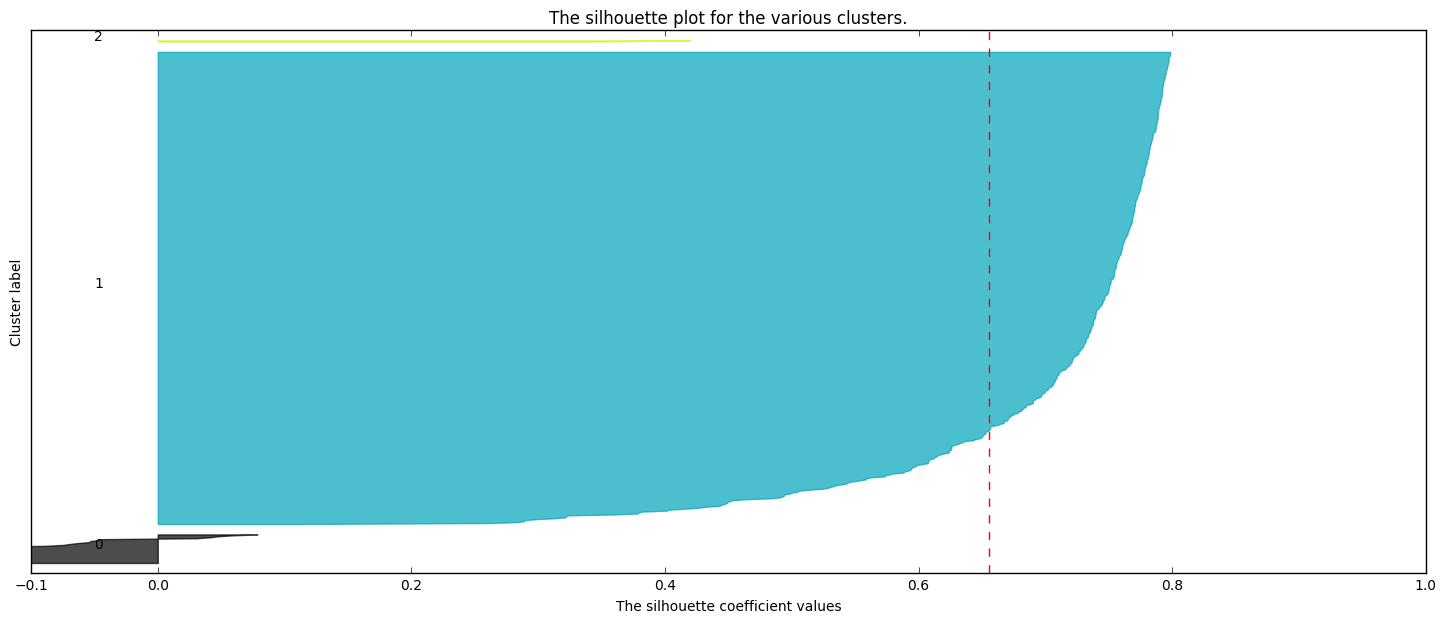

In [27]:
#fig, (ax1, ax2) = plt.subplots(1, 2)
cluster_labels = km.predict(X)
fig, (ax1) = plt.subplots(1)
fig.set_size_inches(18, 7)
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, tf.shape[0] + (n_clusters + 1) * 10])
silhouette_avg = silhouette_score(tf, cluster_labels)
sample_silhouette_values = silhouette_samples(tf, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

colors = cm.spectral(cluster_labels.astype(float) / n_clusters)

In [28]:
output['Cluster'] = km.predict(tf)

C:\Users\v-wihar\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


### Clustering Topics

In [33]:
topic = 'topic_0'
#Scored_words.as_matrix()
X = Scored_words.T.as_matrix()

In [34]:
km = KMeans(n_clusters=5, init='k-means++', max_iter=600, n_init=10)

km.fit(X)
Counter(km.predict(X))

Counter({0: 1, 1: 16, 2: 1, 3: 1, 4: 1})

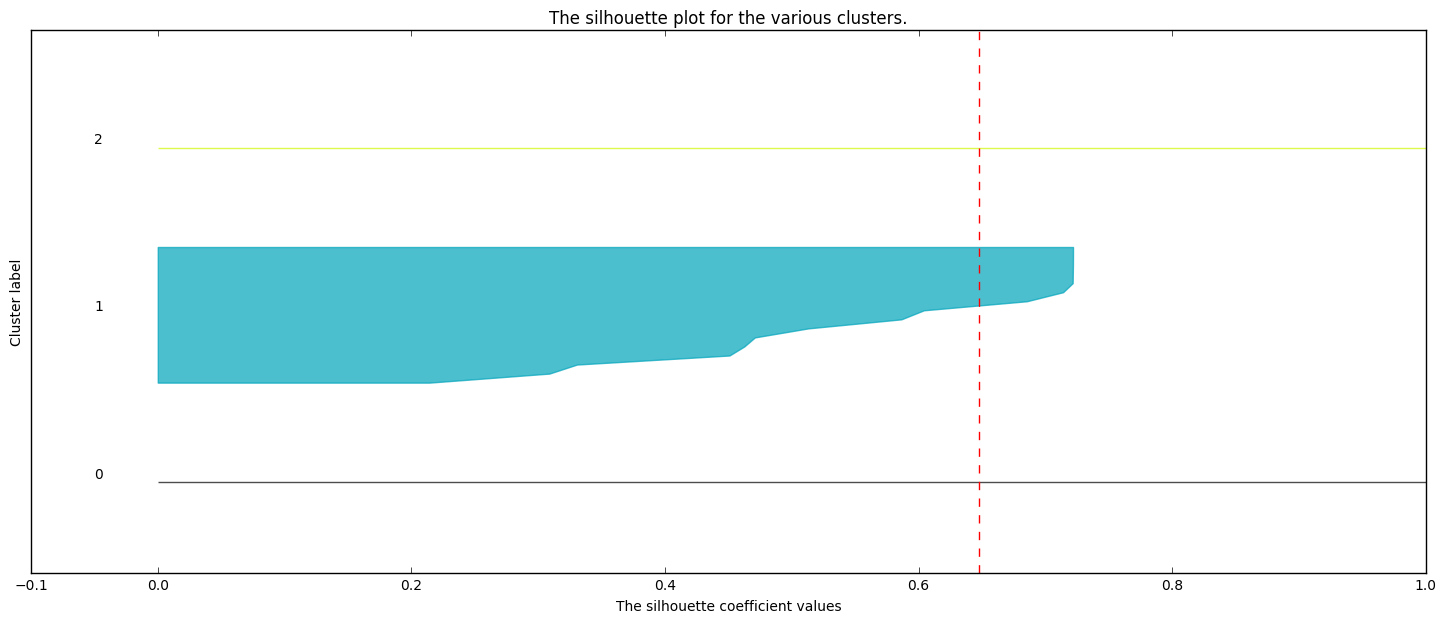

In [35]:
#fig, (ax1, ax2) = plt.subplots(1, 2)
cluster_labels = km.predict(X)
fig, (ax1) = plt.subplots(1)
fig.set_size_inches(18, 7)
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
silhouette_avg = silhouette_score(X, cluster_labels)
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

colors = cm.spectral(cluster_labels.astype(float) / n_clusters)

In [36]:
get_topic_names['Cluster'] = km.predict(X)

## Output to Excel:

In [38]:
writer = pd.ExcelWriter(r'C:\Users\Template.xlsx')
by_type.to_excel(writer,'by type')
by_source.to_excel(writer,'by source')
Scored_words.to_excel(writer,'TFIDF Scored words')
norm_scored_words.to_excel(writer,'Normalized word scores')
topics_by_words.to_excel(writer,'Topics by Normalized Score')
output.to_excel(writer,'Scored Documents')
get_topic_names.to_excel(writer,'Autogen topic names')
writer.save()